## Importación de las librerías

In [56]:
from scipy import stats

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Importación del dataset

Variables:
- id: identificador único
- gender: "Masculino", "Femenino" u "Otro".
- age: edad del paciente
- hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión
- heart_disease: 0 si el paciente no tiene ninguna cardiopatía, 1 si el paciente tiene una cardiopatía
- ever_married: "No" o "Sí"
- work_type: "niños", "Govt_jov", "Nunca_trabajó", "Privado" o "Autónomo"
- residence_type: "Rural" o "Urbana"
- avg_glucose_level: nivel medio de glucosa en sangre
- bmi: índice de masa corporal
- smoking_status: "antes fumaba", "nunca ha fumado", "fuma" o "desconocido". "Desconocido" significa que la información no está disponible para este paciente
- stroke: 1 si el paciente sufrió un ictus o 0 en caso contrario

In [3]:
stroke_df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Número de filas y variables

In [4]:
stroke_df.shape

(5110, 12)

## Análisis exploratorio de los datos

### Descripción inicial

Descripción inicial de las columnas del dataframe.

- La variable id se puede borrar, ya que no aportará nada relevante en la predicción 
- En la variable bmi existen valores perdidos
- hypertension es una variable categorica binaria (0 o 1)
- heart_disease es una variable categorica binaria (0 o 1)

In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Borramos la variable id

In [6]:
del stroke_df['id']

### Ditribución de la variable objetivo

Se observa la distribución inicial de la clase objetivo. Se trata de un dataset bastante desbalanceado.

[Text(0, 0, '4861'), Text(0, 0, '249')]

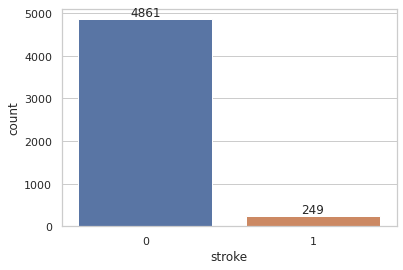

In [7]:
ax = sns.countplot(x='stroke', data=stroke_df)
ax.bar_label(ax.containers[0])

### Variables continuas solas

Realizando una descripción inicial de las variables cuantitativas:
- age: su valor mínimo es 0.08 (en años), lo que significa que existen observaciones que presentan edades en meses
- avg_glucose_level: parece mostrar un valor máximo muy alto y también un mínimo bastante bajo (estudiarlo)
- bmi: posibilidad de la existencia de outliers, valores máximos y mínimos extremos. Además, de que presenta valores perdidos.

In [8]:
stroke_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Distribución de la variable age
- No parecen existir outliers en la variable
- No sigue una forma (parecida) a una normal, pero da igual ya que estamos haciendo un anáslis básico y probaremos diferentes algoritmos de machine learning

<AxesSubplot:xlabel='age', ylabel='Count'>

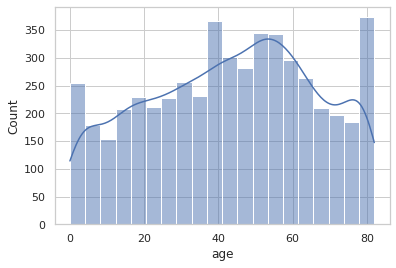

In [9]:
sns.histplot(data=stroke_df, x="age", kde=True)

Posibles outliers en la variable age. No se detectan posibles outliers en la variable age.

<AxesSubplot:xlabel='age'>

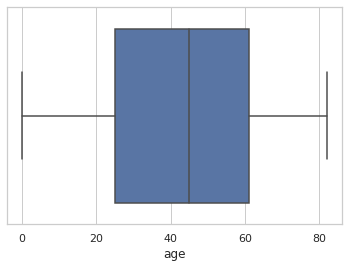

In [10]:
sns.boxplot(x=stroke_df["age"])

Distribución de la variable avg_glucose_level

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

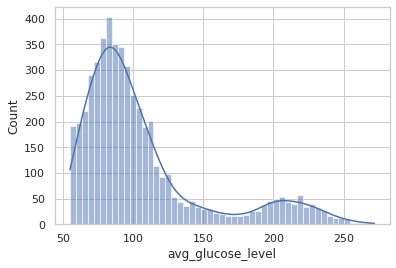

In [11]:
sns.histplot(data=stroke_df, x="avg_glucose_level", kde=True)

Se observan un número alto de observaciones (casi el 12%) que se encuentra por arriba de upper_bound. Esto indica que es posible la existencia de dichos valores lejanos en el dataset analizado.

Puede ser que valores muy altos de dichas variable significen un valor 1 en la variable objetivo a predecir, lo probaremos más adelante.

**Cosas a probar**:
- cambiar escala de la variable, estandarización ¿reduce la cantidad de outliers?

<AxesSubplot:xlabel='avg_glucose_level'>

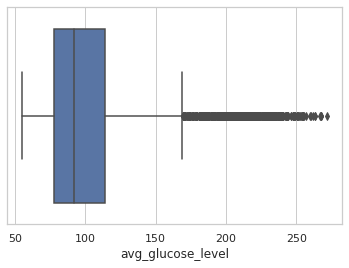

In [12]:
sns.boxplot(x=stroke_df["avg_glucose_level"])

In [13]:
# finding the 1st quartile
q1 = np.quantile(stroke_df.avg_glucose_level, 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(stroke_df.avg_glucose_level, 0.75)
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print("IQR:", iqr, "\nupper:", upper_bound, "\nlower:", lower_bound)

print("\nPosible Outliers:", (stroke_df[stroke_df.avg_glucose_level > upper_bound]).shape[0])

IQR: 36.845 
upper: 169.35750000000002 
lower: 21.977500000000006

Posible Outliers: 627


Distribución de la variable bmi

<AxesSubplot:xlabel='bmi', ylabel='Count'>

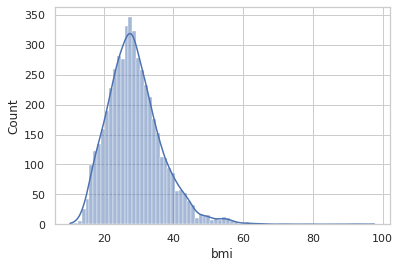

In [14]:
sns.histplot(data=stroke_df, x="bmi", kde=True)

Se observan que existen observaciones que se encuentra por arriba de upper_bound, aunque son solo 110/4909 (tiene datos faltantes) que supone cerca del 2.3% no son muchos. Además, es posible que valores muy altos de bmi significen un valor 1 en la variable objetivo a predecir, lo probaremos más adelante.

**Cosas a probar**:
- cambiar escala de la variable, estandarización ¿reduce la cantidad de outliers?

<AxesSubplot:xlabel='bmi'>

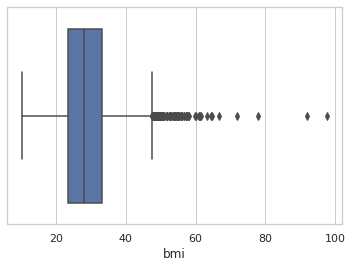

In [17]:
sns.boxplot(x=stroke_df["bmi"])

In [18]:
# finding the 1st quartile
q1 = np.nanquantile(stroke_df.bmi, 0.25)
 
# finding the 3rd quartile
q3 = np.nanquantile(stroke_df.bmi, 0.75)
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print("IQR:", iqr, "\nupper:", upper_bound, "\nlower:", lower_bound)

print("\nPosible Outliers:", (stroke_df[stroke_df.bmi > upper_bound]).shape[0])

IQR: 9.600000000000001 
upper: 47.5 
lower: 9.099999999999998

Posible Outliers: 110


### Variables continuas cruzadas con la objetivo

- Se puede observar que en un principio no se detecta relación lineal o no lineal alguna entre las variables CONTINUAS. Esto se puede confirmar mirando los diferentes scatterplots de abajo.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

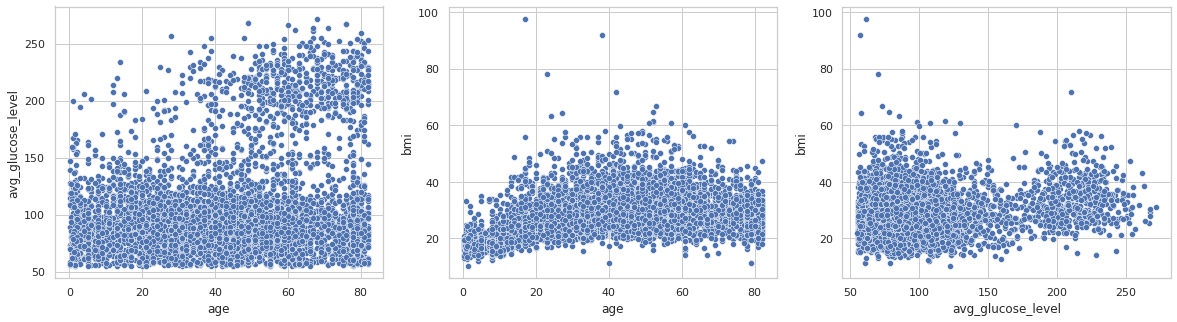

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.scatterplot(data=stroke_df, x="age", y="avg_glucose_level", ax=axes[0])
sns.scatterplot(data=stroke_df, x="age", y="bmi", ax=axes[1])
sns.scatterplot(data=stroke_df, x="avg_glucose_level", y="bmi", ax=axes[2])

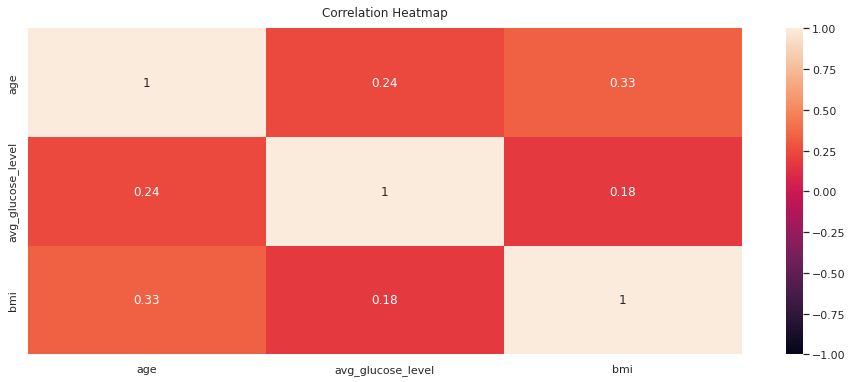

In [31]:
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(stroke_df[['age', 'avg_glucose_level', 'bmi']].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Cruzadas de las variables continuas con la objetivo:
- **age**: se puede observar que las personas que tienen un valor 1 en stroke suelen tener una mayor edad. (**SIRVE PARA DISCRIMINAR A LA VARIABLE OBJETIVO**)
- **avg_glucose_level**: se puede observar que las personas que tienen un valor 1 en stroke suelen tener un mayor nivel medio de glucosa (no parece haber una diferencia significativa). (**TAL VEZ PUEDA SERVIR PARA DISCRIMINAR A LA VARIABLE OBJETIVO**)
- **bmi**: las personas con stroke tienen mayor media, pero no parece ser significativa. (**NO PERMITE DISCRIMINAR A LA VARIABLE OBJETIVO MUCHO**)

<AxesSubplot:xlabel='bmi'>

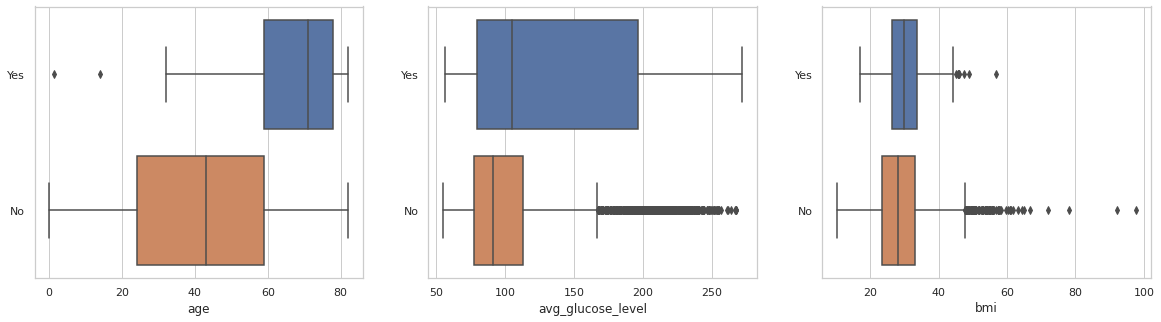

In [55]:
stroke_categorical = ["Yes"  if obs == 1 else "No" for obs in list(stroke_df.stroke)]

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(data=stroke_df, x="age", y=stroke_categorical, ax=axes[0])
sns.boxplot(data=stroke_df, x="avg_glucose_level", y=stroke_categorical, ax=axes[1])
sns.boxplot(data=stroke_df, x="bmi", y=stroke_categorical, ax=axes[2])

Aplicamos el test de **Kruskal-Wallis H-test** para las siguientes hipotesis:
- H0: la mediana de la población de todos los grupos es igual
- H1: H0 no es cierta

En las tres variables continuas parece ser que la mediana de la población no es igual en ambos grupos (0 vs 1)

In [89]:
# AGE: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].age), list(stroke_df.loc[stroke_df.stroke == 0].age)))

# AVG_GLUCOSE_LEVEL: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].avg_glucose_level), list(stroke_df.loc[stroke_df.stroke == 0].avg_glucose_level)))

# BMI: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].bmi), list(stroke_df.loc[stroke_df.stroke == 0].bmi), nan_policy='omit'))

KruskalResult(statistic=318.1166209843264, pvalue=3.725166547874254e-71)
KruskalResult(statistic=34.80739568673386, pvalue=3.639881441958809e-09)
KruskalResult(statistic=15.087653240803583, pvalue=0.00010263237377217099)
